<a href="https://colab.research.google.com/github/PanLuochuan/MachineLearing/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
red= pd.read_csv('/content/drive/MyDrive/winequality-red.csv',sep=";")

In [ ]:
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
red.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [ ]:
red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
value_quality=red['quality'].value_counts()
print(value_quality)

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [ ]:
correlation=red.corr()

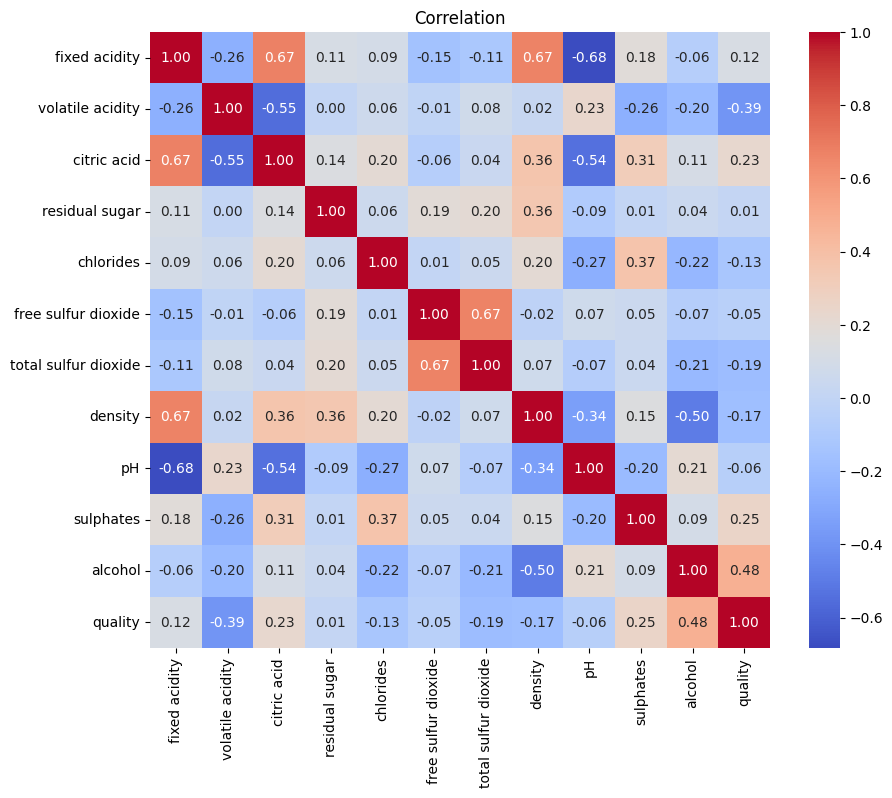

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation")
plt.show()

In [4]:
X=red.drop(columns=['quality'])

In [5]:
y=red.quality

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

向前+交叉验证法

In [ ]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum() #计算残差平方和
    return {"model":regr, "RSS":RSS}

In [ ]:
def forward(predictors, X_train, y_train, X_test, y_test):

    results = []
    remaining_predictors = [p for p in X_train.columns if p not in predictors]

    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))

    models = pd.DataFrame(results)

    best_model = models.loc[models['RSS'].argmin()]

    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
k = 10
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)#分配一个从 0 到 k-1

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1, len(X.columns)+1)) #存储计算出的交叉验证误差
cv_errors = cv_errors.fillna(0)

In [ ]:
models_cv = pd.DataFrame(columns=["RSS", "model"])

# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []

    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):

        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)], X[folds == (j-1)], y[folds == (j-1)])

        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names

<ipython-input-28-167ae1e170dd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-28-167ae1e170dd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-28-167ae1e170dd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-28-167ae1e170dd>:16: SettingWithCopyWarning: 
A valu

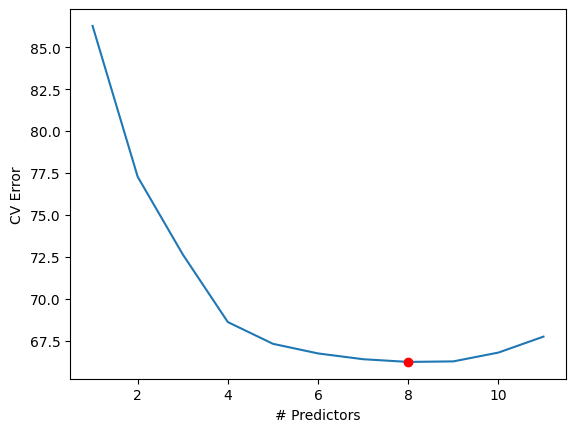

In [ ]:
cv_errors
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

In [ ]:
print(models_cv.loc[8 , "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.328e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):                        0.00
Time:                        15:12:26   Log-Likelihood:                         -1450.6
No. Observations:                1448   AIC:                                      2917.
Df Residuals:                    1440   BIC:                                      2960.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Text(0, 0.5, 'BIC')

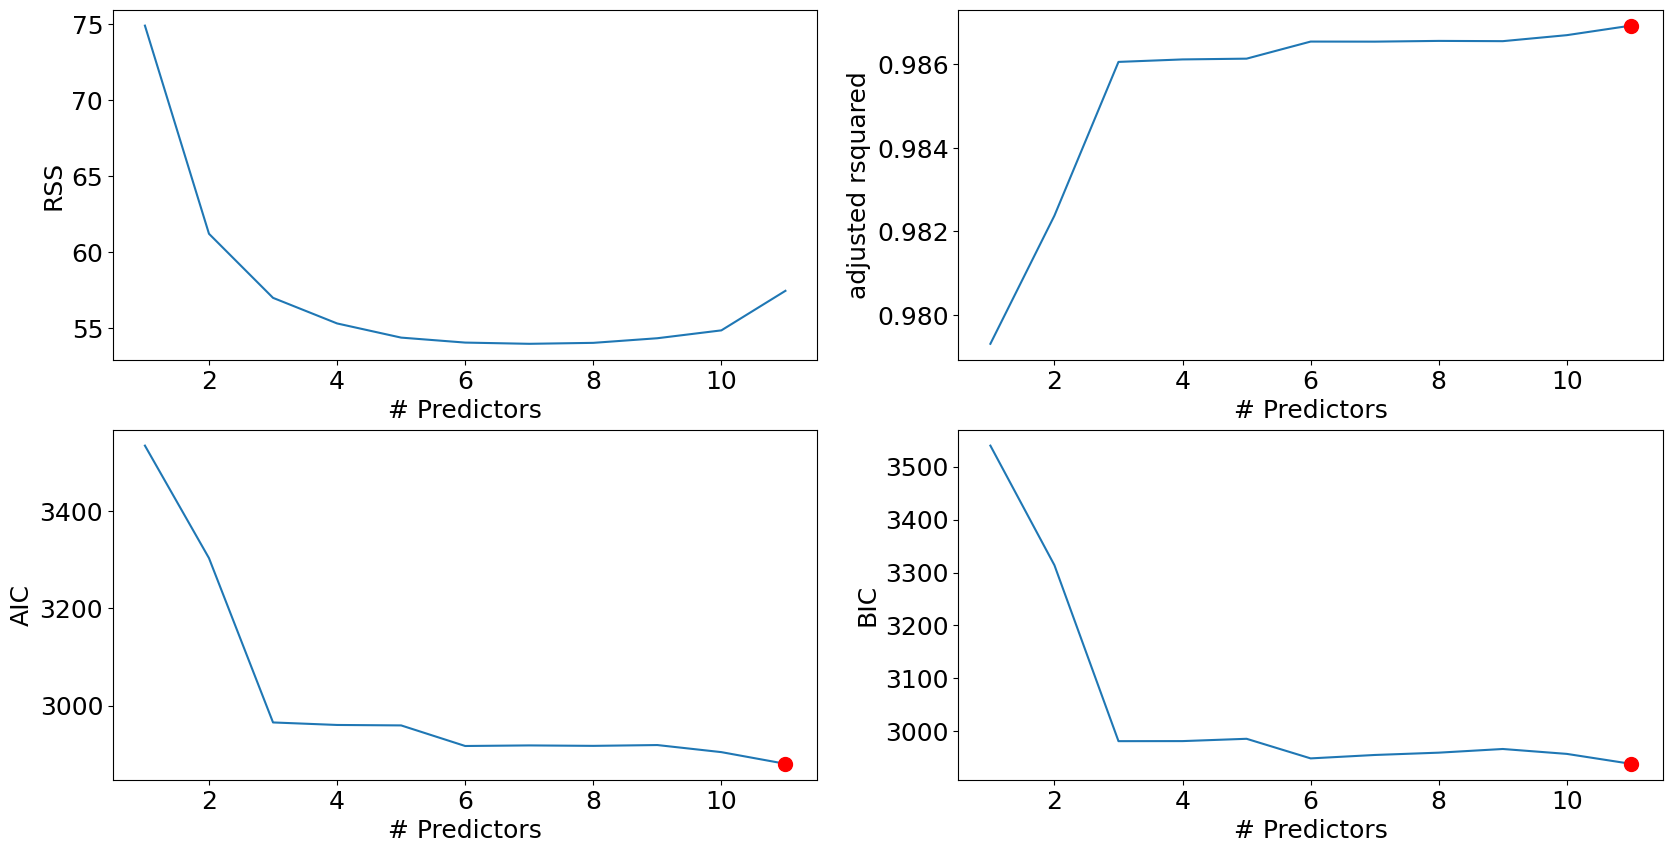

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
print(models_cv.loc[10 , "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.074e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):                        0.00
Time:                        15:23:14   Log-Likelihood:                         -1442.2
No. Observations:                1448   AIC:                                      2904.
Df Residuals:                    1438   BIC:                                      2957.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

选择10个预测变量的模型，因为AIC和BIC更低，预测的准确性更好

向后+交叉验证

In [9]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
   #计算残差平方和
    return {"model":regr, "RSS":RSS}

In [10]:
def backward(predictors, X_train, y_train, X_test, y_test):


    results = []

    for combo in itertools.combinations(predictors, len(predictors)-1):
      if len(combo)==0:
        continue
        #itertools.combinations 生成当前预测变量集
      results.append(processSubset(combo, X_train, y_train, X_test, y_test))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    # Return the best model, along with some other useful information about the model
    return best_model

In [28]:
k = 10        # number of folds
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)#分配一个从 0 到 k-1

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1, len(X.columns)+1)) #存储计算出的交叉验证误差
cv_errors = cv_errors.fillna(0)

In [29]:
models_cv = pd.DataFrame(columns=["RSS", "model"])

# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = list(X.columns)

    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)):

        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = backward(predictors, X[folds != (j-1)], y[folds != (j-1)], X[folds == (j-1)], y[folds == (j-1)])

        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names

        if len(predictors)==1:
          break


<ipython-input-29-0a1bb3042e10>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-29-0a1bb3042e10>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-29-0a1bb3042e10>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-29-0a1bb3042e10>:16: SettingWithCopyWarning: 
A valu

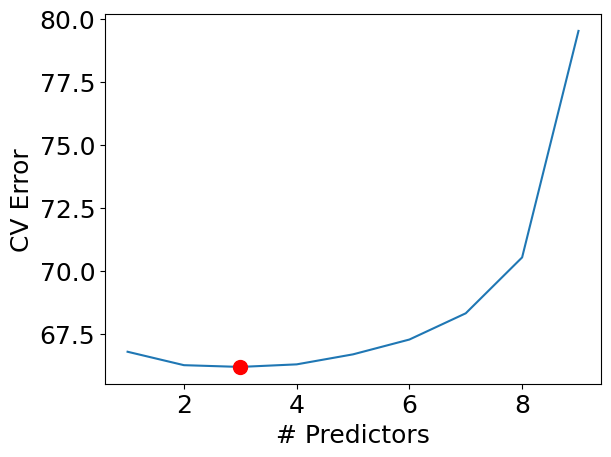

In [24]:
cv_errors
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

Text(0, 0.5, 'BIC')

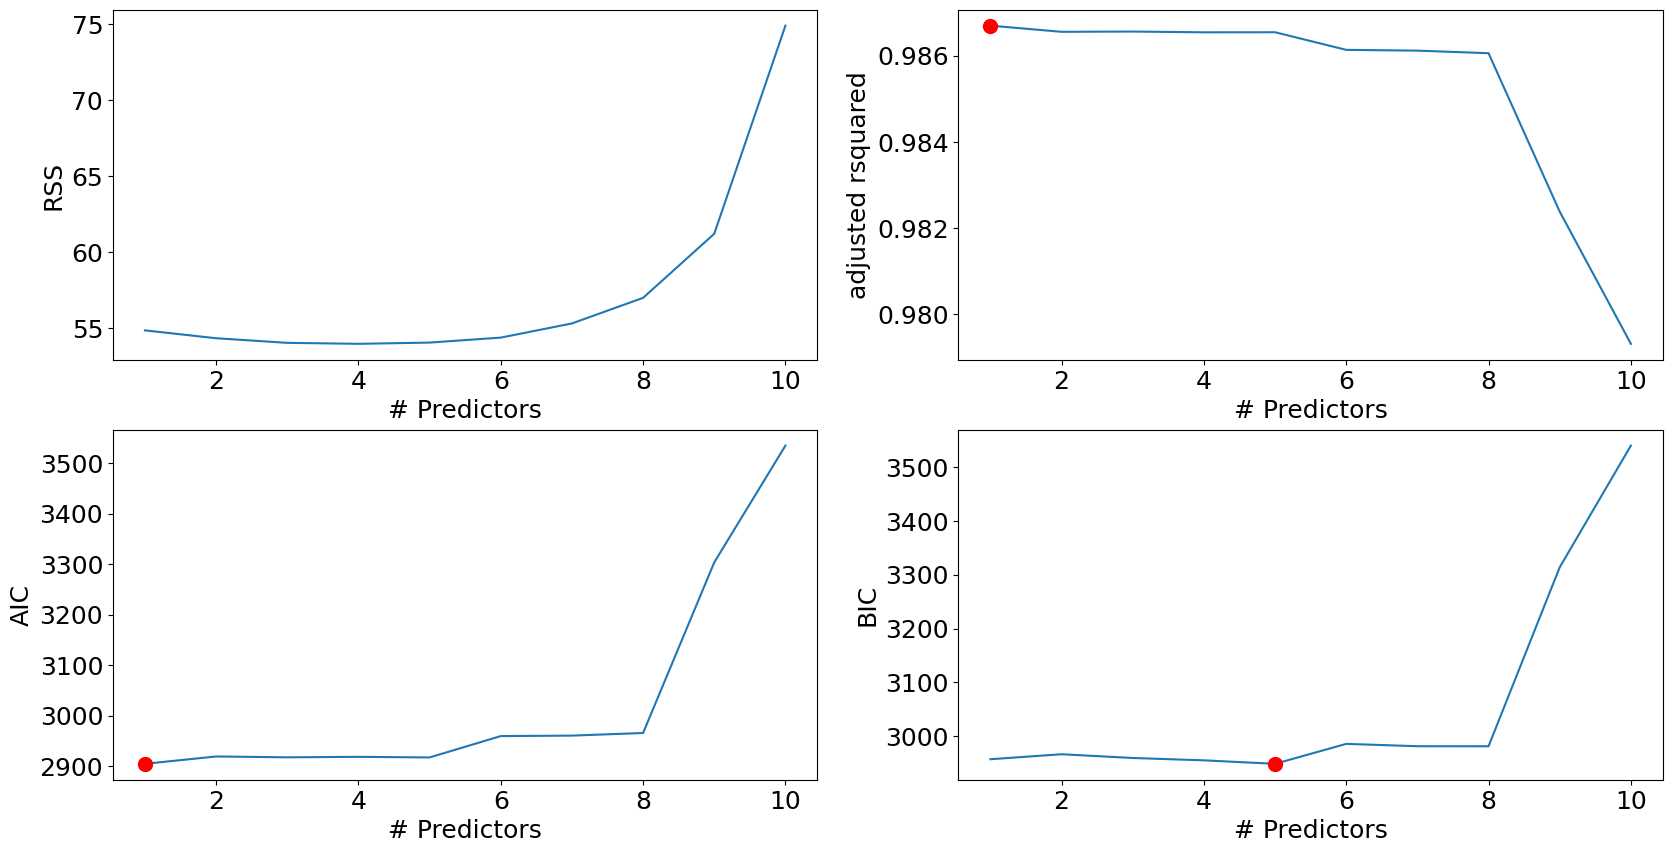

In [25]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [31]:
print(models_cv.loc[2 , "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.180e+04
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        15:48:43   Log-Likelihood:                         -1450.5
No. Observations:                1448   AIC:                                      2919.
Df Residuals:                    1439   BIC:                                      2966.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

向前向后+交叉验证

In [32]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
   #计算残差平方和
    return {"model":regr, "RSS":RSS}

In [33]:
def forward(predictors, X_train, y_train, X_test, y_test):
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors + [p], X_train, y_train, X_test, y_test))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model

In [34]:
def backward(predictors, X_train, y_train, X_test, y_test):
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo, X_train, y_train, X_test, y_test))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model

In [36]:
def forward_backward(X, y, k):
    np.random.seed(seed=1)
    folds = np.random.choice(k, size=len(y), replace=True)
    cv_errors = pd.DataFrame(columns=range(1, k+1), index=range(1, len(X.columns)+1))
    models_cv = pd.DataFrame(columns=["RSS", "model"])

    for j in range(1, k+1):
        predictors = []

        # Forward selection
        while len(predictors) < len(X.columns):
            forward_model = forward(predictors, X[folds != (j-1)], y[folds != (j-1)], X[folds == (j-1)], y[folds == (j-1)])
            predictors = forward_model['model'].model.exog_names[1:]  # remove constant
            models_cv.loc[len(predictors)] = forward_model

        # Backward elimination from the full model
        while len(predictors) > 1:
            backward_model = backward(predictors, X[folds != (j-1)], y[folds != (j-1)], X[folds == (j-1)], y[folds == (j-1)])
            predictors = backward_model['model'].model.exog_names[1:]  # remove constant
            models_cv.loc[len(predictors)] = backward_model

        # Store CV errors
        for i in models_cv.index:
            cv_errors.loc[i, j] = models_cv.loc[i, "RSS"]

    return cv_errors, models_cv

# Example of how to call the function
X = pd.DataFrame(X_train)  # your data
y = pd.Series(y_train)     # your target variable
k = 10  # number of folds

cv_errors, models_cv = forward_backward(X, y, k)

KeyboardInterrupt: 